In [1]:
# ───────────────────────────────
# 📦 Standard Libraries
# ───────────────────────────────
import os
import sys
import math
import time
import csv
import pickle
from datetime import datetime, timedelta
from collections import Counter

# ───────────────────────────────
# 📚 Data Handling & Utilities
# ───────────────────────────────
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import h5py
from joblib import dump, load

# ───────────────────────────────
# 📊 Visualization
# ───────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────
# 📈 Machine Learning
# ───────────────────────────────
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_curve, roc_auc_score, auc,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# ───────────────────────────────
# 🌍 Seismology & Signal Processing
# ───────────────────────────────
import obspy
from obspy import UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.fdsn import Client
from obspy.signal.filter import envelope
from scipy import stats, signal

# ───────────────────────────────
# 🔗 External Tools
# ───────────────────────────────
from zenodo_get import zenodo_get

# ───────────────────────────────
# 🤖 Deep Learning
# ───────────────────────────────
import torch
import torch.nn.functional as F


# ───────────────────────────────
# 🛠 Custom Utilities
# ───────────────────────────────
sys.path.insert(0, '/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts')
from neural_network_architectures import SeismicCNN_2d

from utils import (
    extract_waveforms,
    compute_spectrogram,
    normalize_spectrogram_minmax,
    return_train_val_loaders,
    plot_confusion_matrix_and_cr,
    train_model,
    WaveformPreprocessor
)

# Pandas display options
pd.set_option('display.max_columns', None)


sys.path.append('/home/ak287/seisbench/seisbench/models')
import seisbench.models as sbm



# for extracting unique stations
import re
from pathlib import Path

cuda


In [2]:
## setting up some important parameters (not to be changed)
num_channels = 3
dropout = 0.9
# Check if a GPU is available
device = "cuda"



model_quakexnet_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available

# Load the saved model state dict (weights)
saved_model_quakexnet_2d = torch.load('../trained_models/best_model_new_augmented_esec_SeismicCNN_2d.pth', map_location=torch.device('cpu'))  # No 'weights_only' argument
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)
model_quakexnet_2d.to(device)
model_quakexnet_2d.eval()


model = model_quakexnet_2d
model.to('cuda')


SeismicCNN_2d(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=15360, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.9, inplace=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [13]:
vlp_cat = pd.read_csv('../../data/baker_vlp/MountBaker_Event_Classification_Reanalysis.csv')
vlp_cat

,Unnamed: 0,etype,lat,lon,depth,prefor_time,mag,magtype,offset_km,tidy_group,petype
0,uw10835733,uk,48.799833,-121.699833,18000.0,1969-10-02 11:17:43.000,2.50,Md,9.048559,-2.0,uk
1,uw10857743,eq,48.656333,-121.682000,-1214.0,1973-11-11 19:01:57.980,1.80,Md,16.463935,-2.0,eq
2,uw10857783,eq,48.807167,-122.078500,3176.0,1973-11-20 13:35:10.130,2.40,Md,19.484345,-2.0,eq
3,uw10845458,eq,48.692833,-121.833667,-312.0,1977-12-28 21:13:00.710,1.10,Md,9.161292,-2.0,eq
4,uw10849148,eq,48.768500,-121.799500,-828.0,1979-03-11 05:35:18.400,1.50,Md,1.458723,-2.0,eq
...,...,...,...,...,...,...,...,...,...,...,...
1543,uw62076866,px,49.124667,-122.124333,-690.0,2025-02-21 23:07:39.010,1.48,Ml,44.936290,-2.0,px
1544,uw62077456,eq,48.340167,-121.746833,3470.0,2025-02-24 10:10:14.240,0.64,Ml,48.574738,-2.0,eq
1545,uw62078286,px,49.119167,-122.122667,-680.0,2025-02-26 22:36:45.280,0.89,Md,44.346643,-2.0,px
1546,uw62078526,eq,48.767500,-122.308667,14620.0,2025-02-28 02:28:49.800,1.06,Ml,36.027255,-2.0,eq


In [15]:
# create a new column (recommended so you keep the raw strings too)
vlp_cat["prefor_time_utc"] = vlp_cat["prefor_time"].apply(obspy.UTCDateTime)

In [19]:
st_time = vlp_cat['prefor_time_utc'].values[-2]
end_time = st_time + 1000


2025-02-28T02:28:49.800000Z

Inventory created at 2025-06-28T20:08:40.447500Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2025-02-28...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			UW
		Stations (1):
			UW.MBW2 (Mt Baker West 2, WA, USA)
		Channels (23):
			UW.MBW2..ENZ, UW.MBW2..ENN, UW.MBW2..ENE, UW.MBW2..HHZ, 
			UW.MBW2..HHN, UW.MBW2..HHE, UW.MBW2.D0.GAN, UW.MBW2.D0.GEL, 
			UW.MBW2.D0.GLA, UW.MBW2.D0.GLO, UW.MBW2.D0.GNS, UW.MBW2.D0.GPL, 
			UW.MBW2.D0.GST, UW.MBW2.D0.LCE, UW.MBW2.D0.LCQ, UW.MBW2.D0.VCO, 
			UW.MBW2.D0.VDT, UW.MBW2.D0.VEC, UW.MBW2.D0.VEI, UW.MBW2.D0.VM1, 
			UW.MBW2.D0.VM2, UW.MBW2.D0.VM3, UW.MBW2.D0.VPB


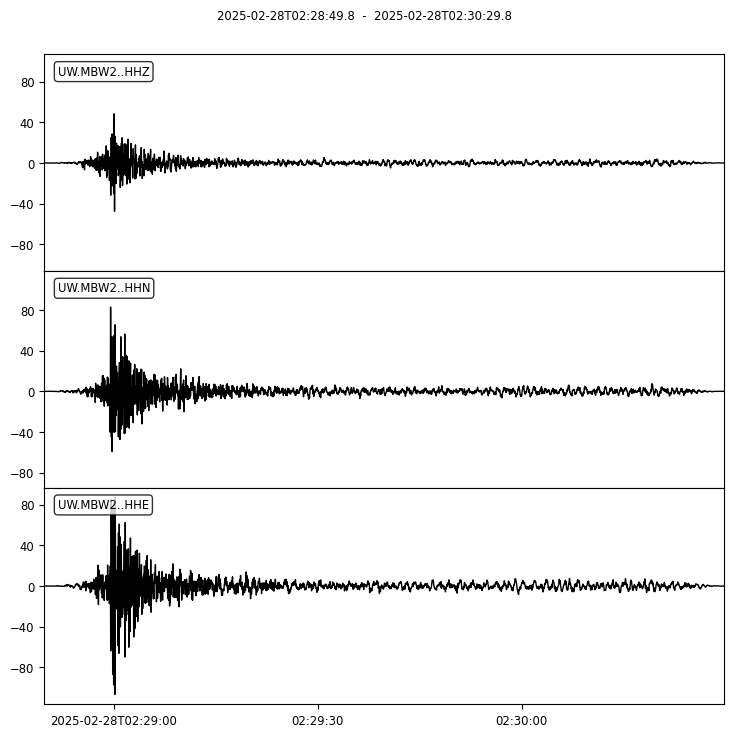

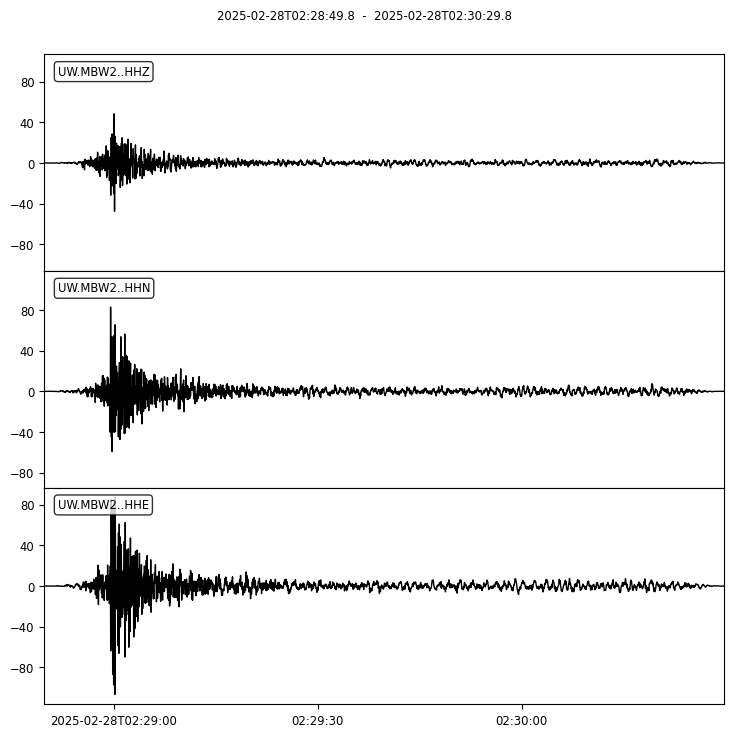

In [27]:
# (1) Make sure st_time / end_time are UTCDateTime objects
st_time = vlp_cat["prefor_time_utc"].iloc[-2]      # already UTCDateTime
end_time = st_time + 100                          # 1 000 s (~16.7 min)

# (2) Connect to IRIS (change base_url if you use another data center)
client = Client("IRIS")

# (3) Inspect what channels are available in that time span
inv = client.get_stations(
    network="UW", station="MBW2", location="*", channel="*",
    starttime=st_time, endtime=end_time, level="channel"
)
print(inv)  # Optional: lets you see HH?, BH?, etc.

# (4) Request the three components in one call (here HH? as an example)
st = client.get_waveforms(
    network="UW", station="MBW2",
    location="*",        # "*" grabs whatever LOC IDs exist (often "00" or "--")
    channel="*H*",       # change to "BH?" if BHZ/BHN/BHE is what you need
    starttime=st_time, endtime=end_time,
    attach_response=True # include instrument response in the MiniSEED
)

# (5) Basic clean-up (optional but common)
st.detrend("linear")
st.taper(0.1)
st.filter('bandpass', freqmin = 1, freqmax = 10)
st.merge()                  # fills gaps, sorts traces

#st.remove_response(output="VEL")  # convert to velocity (nm/s by default)

# Now `st` holds three traces (Z, N, E) ready for further processing
st.plot()

Inventory created at 2025-06-28T20:12:08.393900Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2025-02-28...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			UW
		Stations (1):
			UW.MBW2 (Mt Baker West 2, WA, USA)
		Channels (23):
			UW.MBW2..ENZ, UW.MBW2..ENN, UW.MBW2..ENE, UW.MBW2..HHZ, 
			UW.MBW2..HHN, UW.MBW2..HHE, UW.MBW2.D0.GAN, UW.MBW2.D0.GEL, 
			UW.MBW2.D0.GLA, UW.MBW2.D0.GLO, UW.MBW2.D0.GNS, UW.MBW2.D0.GPL, 
			UW.MBW2.D0.GST, UW.MBW2.D0.LCE, UW.MBW2.D0.LCQ, UW.MBW2.D0.VCO, 
			UW.MBW2.D0.VDT, UW.MBW2.D0.VEC, UW.MBW2.D0.VEI, UW.MBW2.D0.VM1, 
			UW.MBW2.D0.VM2, UW.MBW2.D0.VM3, UW.MBW2.D0.VPB


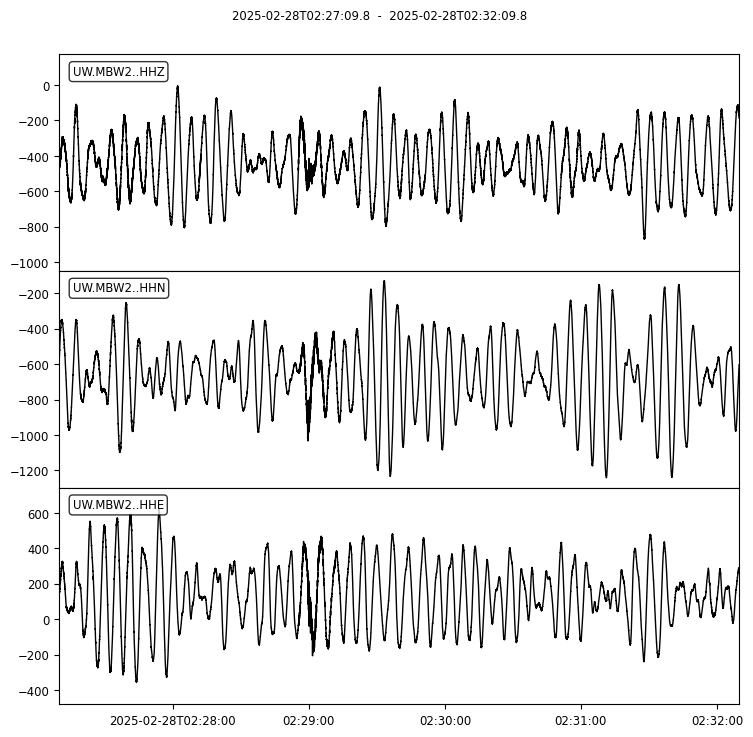

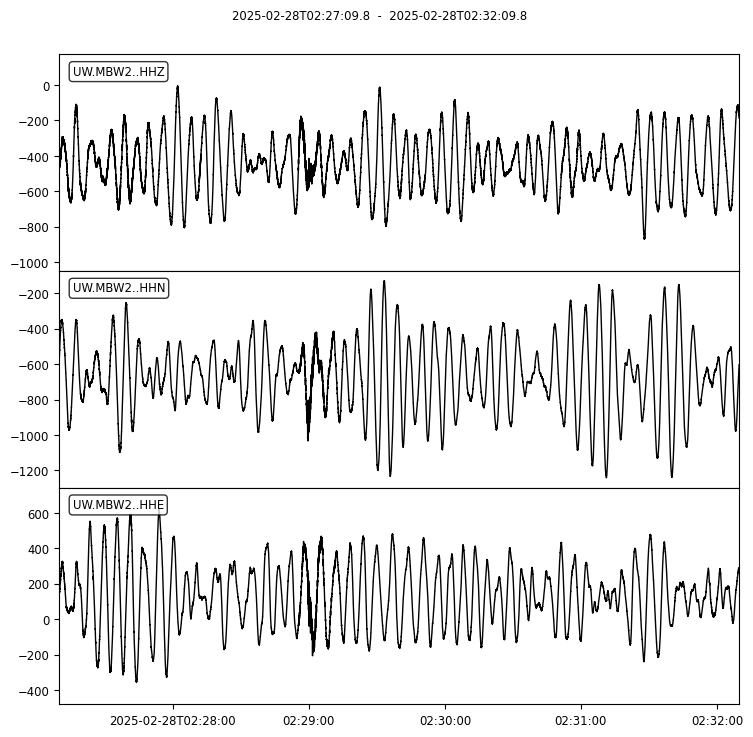

In [32]:
# (1) Make sure st_time / end_time are UTCDateTime objects
st_time = vlp_cat["prefor_time_utc"].iloc[-2] - 0      # already UTCDateTime
end_time = st_time + 300                          # 1 000 s (~16.7 min)

# (2) Connect to IRIS (change base_url if you use another data center)
client = Client("IRIS")

# (3) Inspect what channels are available in that time span
inv = client.get_stations(
    network="UW", station="MBW2", location="*", channel="*",
    starttime=st_time, endtime=end_time, level="channel"
)
print(inv)  # Optional: lets you see HH?, BH?, etc.

# (4) Request the three components in one call (here HH? as an example)
st = client.get_waveforms(
    network="UW", station="MBW2",
    location="*",        # "*" grabs whatever LOC IDs exist (often "00" or "--")
    channel="*H*",       # change to "BH?" if BHZ/BHN/BHE is what you need
    starttime=st_time, endtime=end_time,
    attach_response=True # include instrument response in the MiniSEED
)

# (5) Basic clean-up (optional but common)
#st.detrend("linear")
#st.filter('bandpass', freqmin = 1, freqmax = 10)
#st.merge()                  # fills gaps, sorts traces

#st.remove_response(output="VEL")  # convert to velocity (nm/s by default)

# Now `st` holds three traces (Z, N, E) ready for further processing
st.plot()

In [33]:
#model1 = sbm.QuakeXNetoneD.from_pretrained("base")
model2 = sbm.SeismicCNN.from_pretrained("base")

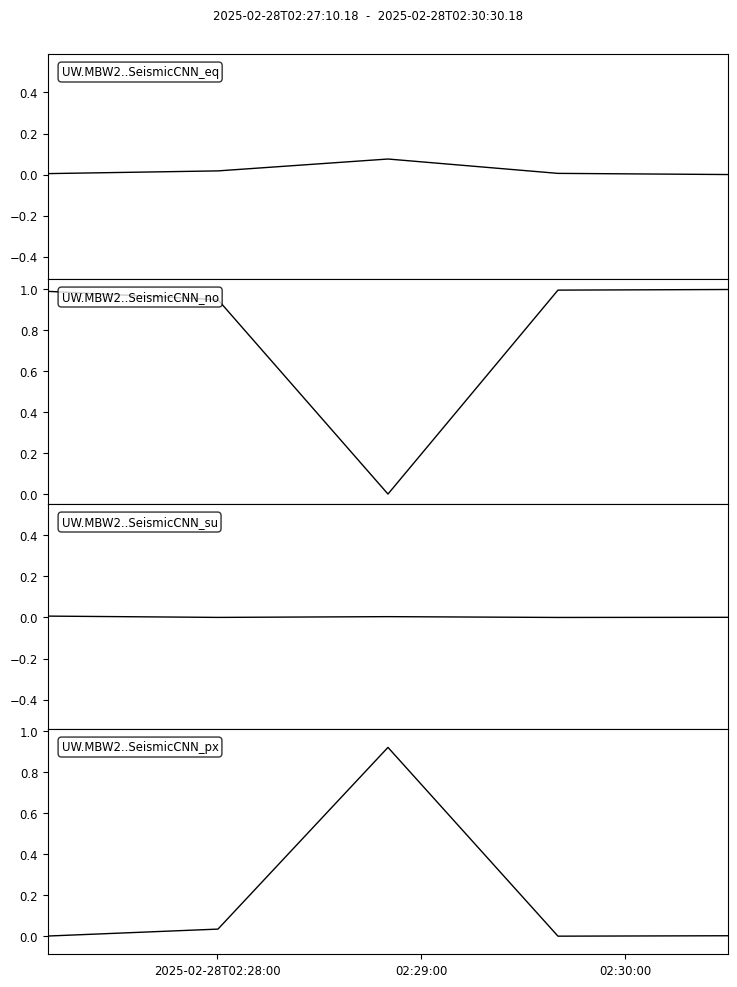

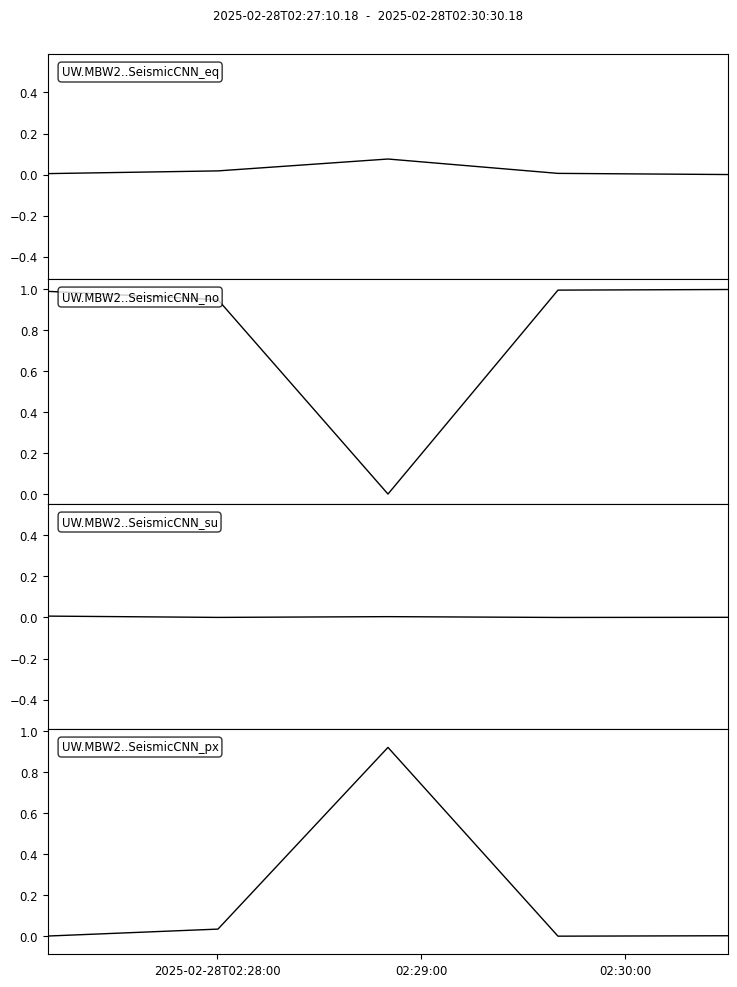

In [35]:
model2.annotate(st).plot()